---------------------------------------------------
# Covid-19-Peak-Predictor-using-FBProphet
---------------------------------------------------
## Author: Viraj Sonavane 
## Enviornment: Google Colab
## Language: Python
---------------------------------------------------
1. Data Source from OUR WORLD in Data GitHub repository.
2. Goal to predict COVID-19 peak using Time Series Analysis
3. Dataset available here: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
from matplotlib import dates
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Javascript
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from google.colab import files
import os
import time
import getpass
import statistics
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from pylab import rcParams
import missingno as msno
!pip install geopandas #for map
import geopandas as gpd
from pandas import DataFrame
from pandas import to_datetime
import ast



import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 55)

#import sklearn packages
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #Dickey-Fuller Test
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import Holt

#Import ARIMA packages
!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import ADFTest

# Use bokeh to plot predictions
import bokeh.io
bokeh.io.reset_output()
bokeh.io.output_notebook()
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.models import NumeralTickFormatter


In [2]:
#loading the URL
covid_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
#read the CSV file
cdata = pd.read_csv(covid_url, error_bad_lines=False)


In [3]:
#Number of columns
cdata.head()

iso_code continent  ... excess_mortality excess_mortality_cumulative_per_million
0      AFG      Asia  ...              NaN                                     NaN
1      AFG      Asia  ...              NaN                                     NaN
2      AFG      Asia  ...              NaN                                     NaN
3      AFG      Asia  ...              NaN                                     NaN
4      AFG      Asia  ...              NaN                                     NaN

[5 rows x 67 columns]

In [4]:
#Display all rows
pd.set_option('display.max_rows',None)

In [5]:
#Total rows
cdata.shape

(139837, 67)

In [6]:
len(cdata.index)

139837

In [7]:
len(cdata.columns)

67

In [8]:
#Checking for null values
cdata.isnull().sum()

iso_code                                           0
continent                                       8890
location                                           0
date                                               0
total_cases                                     7803
new_cases                                       7808
new_cases_smoothed                              8848
total_deaths                                   19176
new_deaths                                     18980
new_deaths_smoothed                             8848
total_cases_per_million                         8479
new_cases_per_million                           8484
new_cases_smoothed_per_million                  9519
total_deaths_per_million                       19839
new_deaths_per_million                         19643
new_deaths_smoothed_per_million                 9519
reproduction_rate                              29307
icu_patients                                  122725
icu_patients_per_million                      

In [9]:
#Dropping unrequired columns
cdata.drop(['excess_mortality_cumulative_per_million','excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','human_development_index','hospital_beds_per_thousand','handwashing_facilities','male_smokers','female_smokers','gdp_per_capita','diabetes_prevalence','cardiovasc_death_rate','extreme_poverty','gdp_per_capita','population_density','reproduction_rate','continent'],axis=1, inplace= True)

In [10]:
cdata.head()

iso_code     location  ... aged_70_older  life_expectancy
0      AFG  Afghanistan  ...         1.337            64.83
1      AFG  Afghanistan  ...         1.337            64.83
2      AFG  Afghanistan  ...         1.337            64.83
3      AFG  Afghanistan  ...         1.337            64.83
4      AFG  Afghanistan  ...         1.337            64.83

[5 rows x 51 columns]

In [11]:
#Checking columns with 80% null values 
cdata.isnull().sum() >= (119656 * 0.80)

iso_code                                      False
location                                      False
date                                          False
total_cases                                   False
new_cases                                     False
new_cases_smoothed                            False
total_deaths                                  False
new_deaths                                    False
new_deaths_smoothed                           False
total_cases_per_million                       False
new_cases_per_million                         False
new_cases_smoothed_per_million                False
total_deaths_per_million                      False
new_deaths_per_million                        False
new_deaths_smoothed_per_million               False
icu_patients                                   True
icu_patients_per_million                       True
hosp_patients                                  True
hosp_patients_per_million                      True
weekly_icu_a

In [12]:
# dropping column with 80% null values
cdata.drop(['icu_patients','icu_patients_per_million','hosp_patients','hosp_patients_per_million','weekly_hosp_admissions','weekly_hosp_admissions_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million'],axis=1,inplace= True)

In [13]:
cdata.head(1)

iso_code     location  ... aged_70_older  life_expectancy
0      AFG  Afghanistan  ...         1.337            64.83

[1 rows x 43 columns]

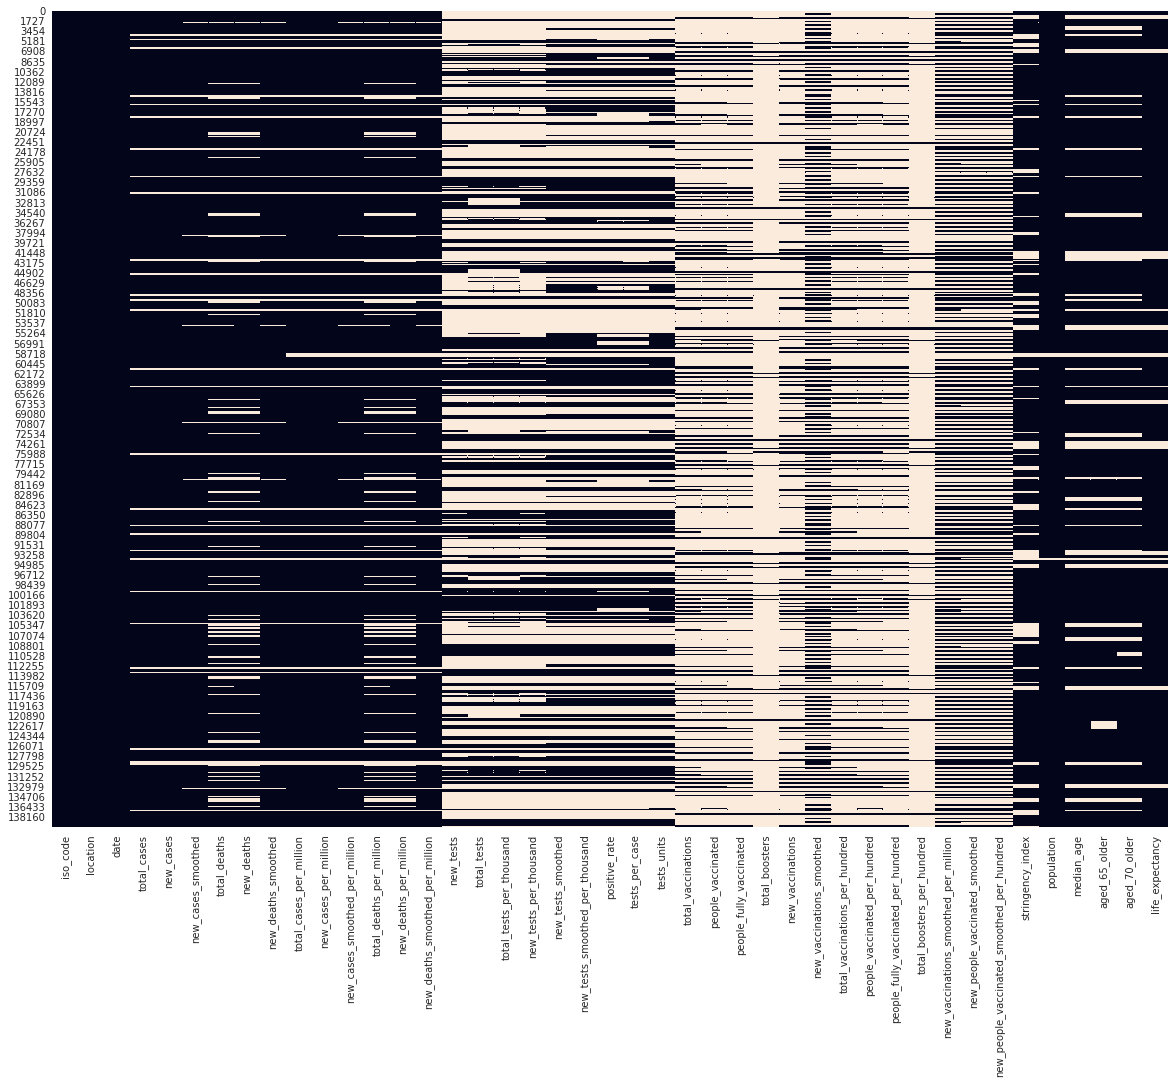

In [14]:
#Checking null values using heatmap
plt.subplots(figsize=(20,15))
sns.heatmap(cdata.isnull(), cbar=False)

In [15]:
#Fill NaN values with 0
cdata.fillna(0,inplace=True)


In [16]:
#Checking if any null values remains
cdata.isnull().sum()

iso_code                                      0
location                                      0
date                                          0
total_cases                                   0
new_cases                                     0
new_cases_smoothed                            0
total_deaths                                  0
new_deaths                                    0
new_deaths_smoothed                           0
total_cases_per_million                       0
new_cases_per_million                         0
new_cases_smoothed_per_million                0
total_deaths_per_million                      0
new_deaths_per_million                        0
new_deaths_smoothed_per_million               0
new_tests                                     0
total_tests                                   0
total_tests_per_thousand                      0
new_tests_per_thousand                        0
new_tests_smoothed                            0
new_tests_smoothed_per_thousand         

In [17]:
cdata.head(10)

iso_code     location  ... aged_70_older  life_expectancy
0      AFG  Afghanistan  ...         1.337            64.83
1      AFG  Afghanistan  ...         1.337            64.83
2      AFG  Afghanistan  ...         1.337            64.83
3      AFG  Afghanistan  ...         1.337            64.83
4      AFG  Afghanistan  ...         1.337            64.83
5      AFG  Afghanistan  ...         1.337            64.83
6      AFG  Afghanistan  ...         1.337            64.83
7      AFG  Afghanistan  ...         1.337            64.83
8      AFG  Afghanistan  ...         1.337            64.83
9      AFG  Afghanistan  ...         1.337            64.83

[10 rows x 43 columns]

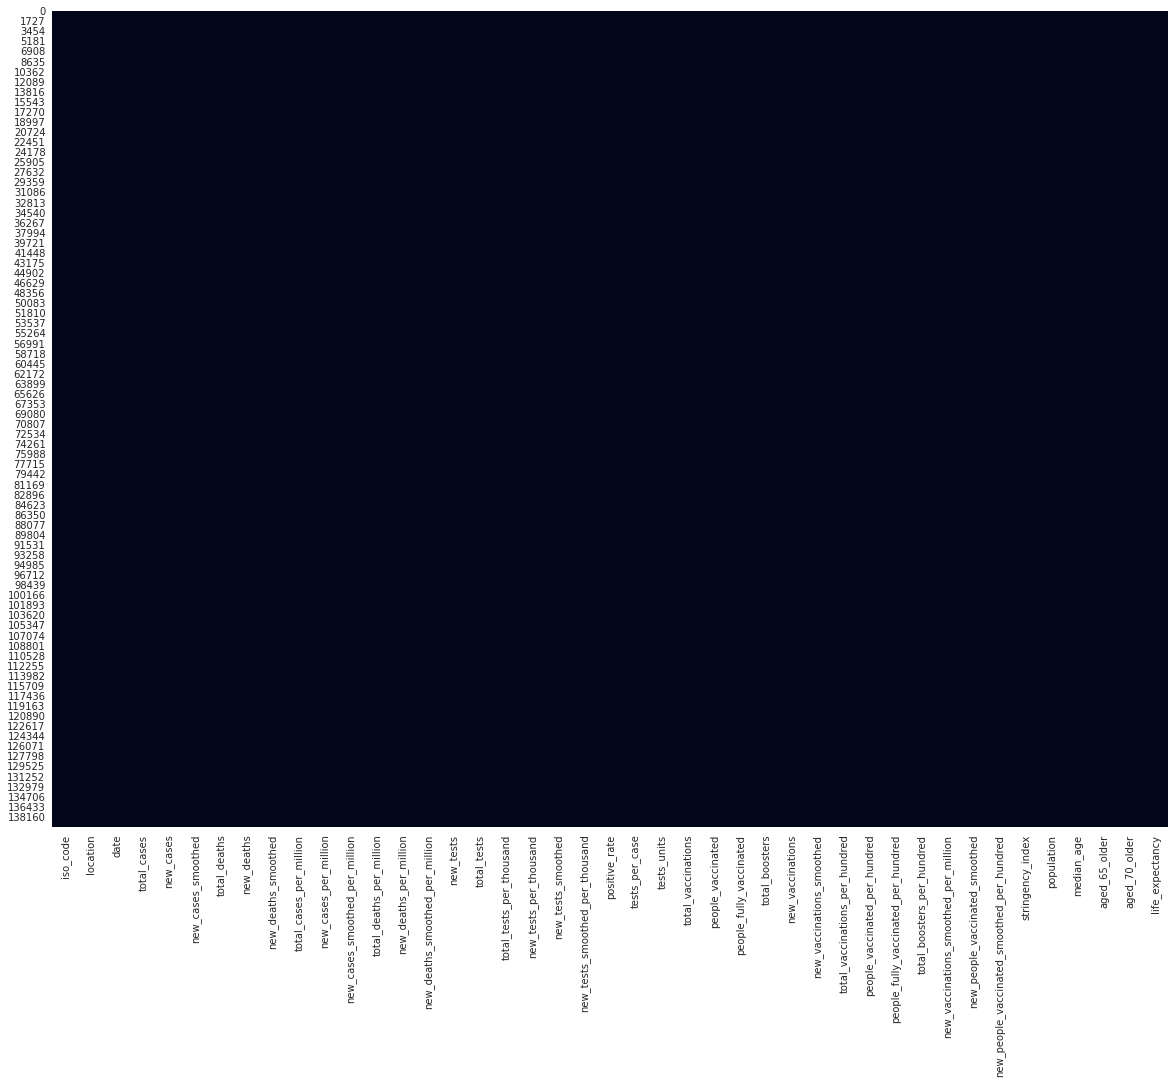

In [18]:
#Checking if any null values remains using heatmap
plt.subplots(figsize=(20,15))
sns.heatmap(cdata.isnull(), cbar=False)

In [19]:
#Getting names of all the available nation in dataset
cdata['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

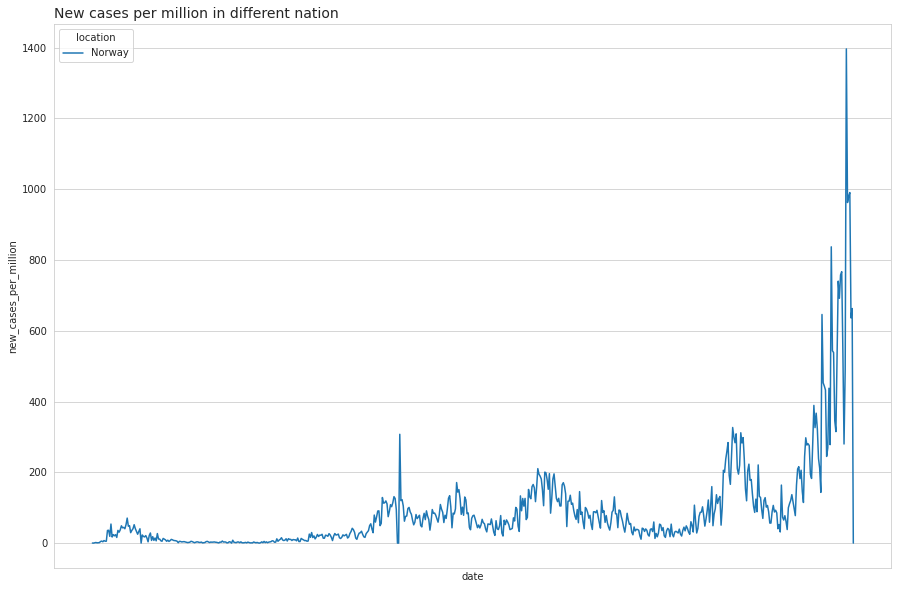

In [20]:
#Ploting location vs new cases per million
plt.figure(figsize=(15,10))
plt.title("New cases per million in different nation",fontsize='14',loc='left')
graph = sns.lineplot(data=cdata[cdata['location'].isin(['Norway'])].sort_values(by='date'), x='date', y='new_cases_per_million',hue='location')
graph.xaxis.set_major_locator(mdates.DayLocator(interval = 60))
plt.xticks(rotation = 'vertical')
plt.show()

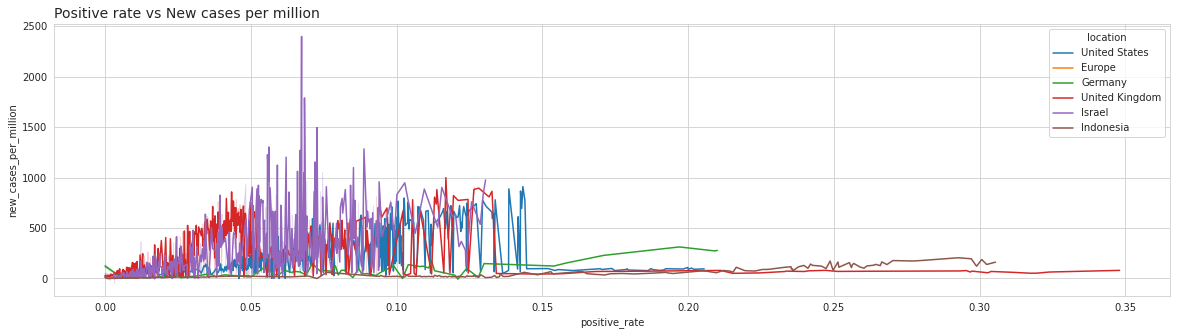

In [21]:
#Plotting People fully vaccinated in USA
plt.figure(figsize=(20,5))
plt.title("Positive rate vs New cases per million",fontsize='14',loc='left')
sns.lineplot(data=cdata[cdata['location'].isin(['United States','Germany','United Kingdom','Europe','Israel','Indonesia'])].sort_values(by='date'), x='positive_rate', y='new_cases_per_million',hue='location')
plt.show()

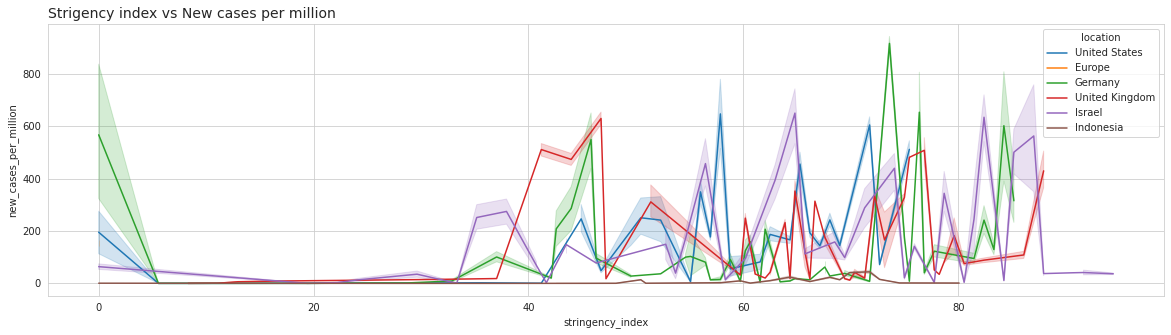

In [22]:
#Plotting People fully vaccinated in USA
plt.figure(figsize=(20,5))
plt.title("Strigency index vs New cases per million",fontsize='14',loc='left')
sns.lineplot(data=cdata[cdata['location'].isin(['United States','Germany','United Kingdom','Europe','Israel','Indonesia'])].sort_values(by='date'), x='stringency_index', y='new_cases_per_million',hue='location')
plt.show()

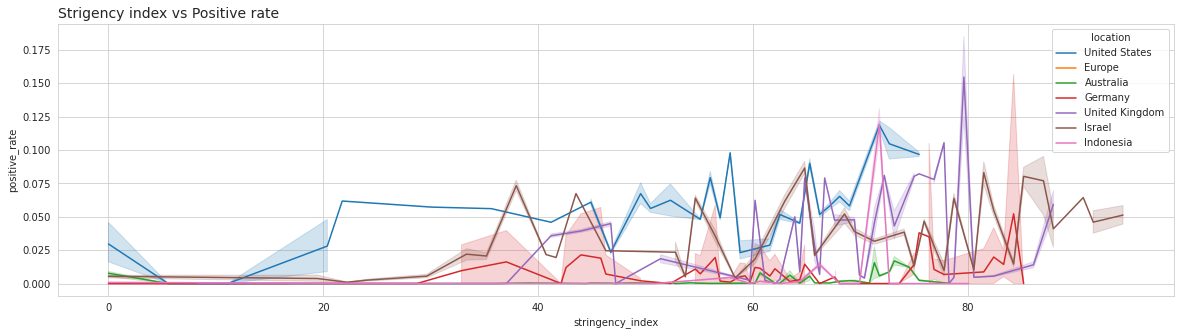

In [23]:
plt.figure(figsize=(20,5))
plt.title("Strigency index vs Positive rate",fontsize='14',loc='left')
sns.lineplot(data=cdata[cdata['location'].isin(['United States','Germany','United Kingdom','Europe','Israel','Indonesia','Australia'])].sort_values(by='date'), x='stringency_index', y='positive_rate',hue='location')
plt.show()

In [24]:
#Plotting WORLDMAP for Stringency index
#Using geopandas datset naturalearth lowres
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(10)

pop_est  ...                                           geometry
0     920938  ...  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...
1   53950935  ...  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...
2     603253  ...  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3   35623680  ...  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4  326625791  ...  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...
5   18556698  ...  POLYGON ((87.35997 49.21498, 86.59878 48.54918...
6   29748859  ...  POLYGON ((55.96819 41.30864, 55.92892 44.99586...
7    6909701  ...  MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...
8  260580739  ...  MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ...
9   44293293  ...  MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...

[10 rows x 6 columns]

In [25]:
#We will join both the data for covid and world map and join it on iso_code
merged = world.set_index('iso_a3').join(cdata.set_index('iso_code')).reset_index()


In [26]:
merged.head(3)

index   pop_est continent  ... aged_65_older  aged_70_older life_expectancy
0   -99   5320045    Europe  ...           NaN            NaN             NaN
1   -99  67106161    Europe  ...           NaN            NaN             NaN
2   -99    265100      Asia  ...           NaN            NaN             NaN

[3 rows x 48 columns]

In [27]:
#Plotting WORLDMAP for Stringency index
def graph_world(feature):
    #whichever data we wish to map we will send in feature
    to_be_mapped = feature
    vmin, vmax = 0,100
    fig, ax = plt.subplots(1, figsize=(25,25))

    merged.plot(column=to_be_mapped, cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolors='1' , legend=True,
                legend_kwds={'label': "new_cases_per_million", 'orientation': "horizontal"})
    ax.set_title('New cases per million', fontdict={'fontsize':20})
    

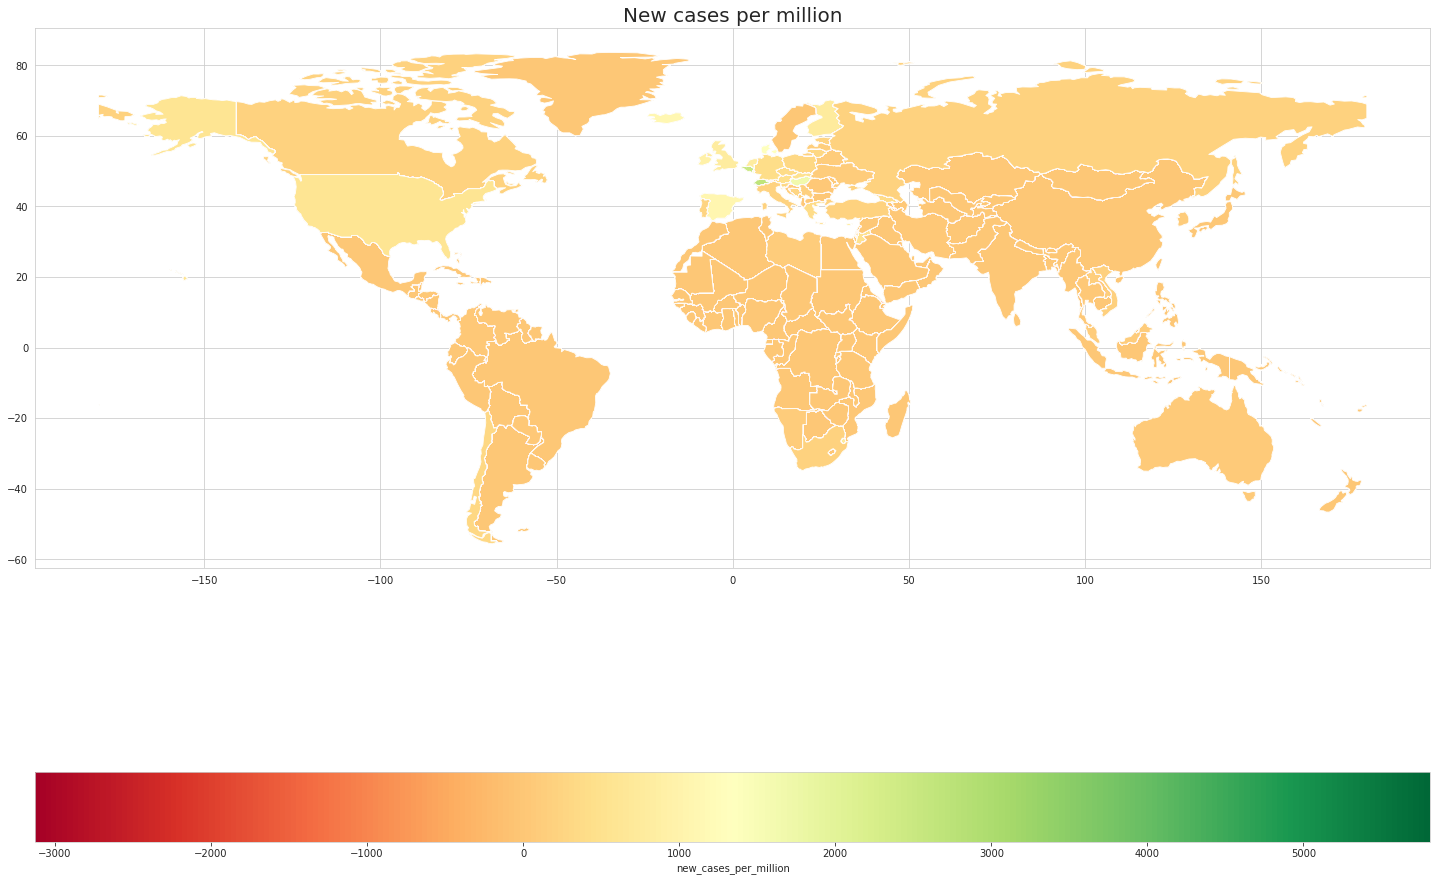

In [28]:
#Plotting WORLDMAP for Stringency index
graph_world('new_cases_per_million')

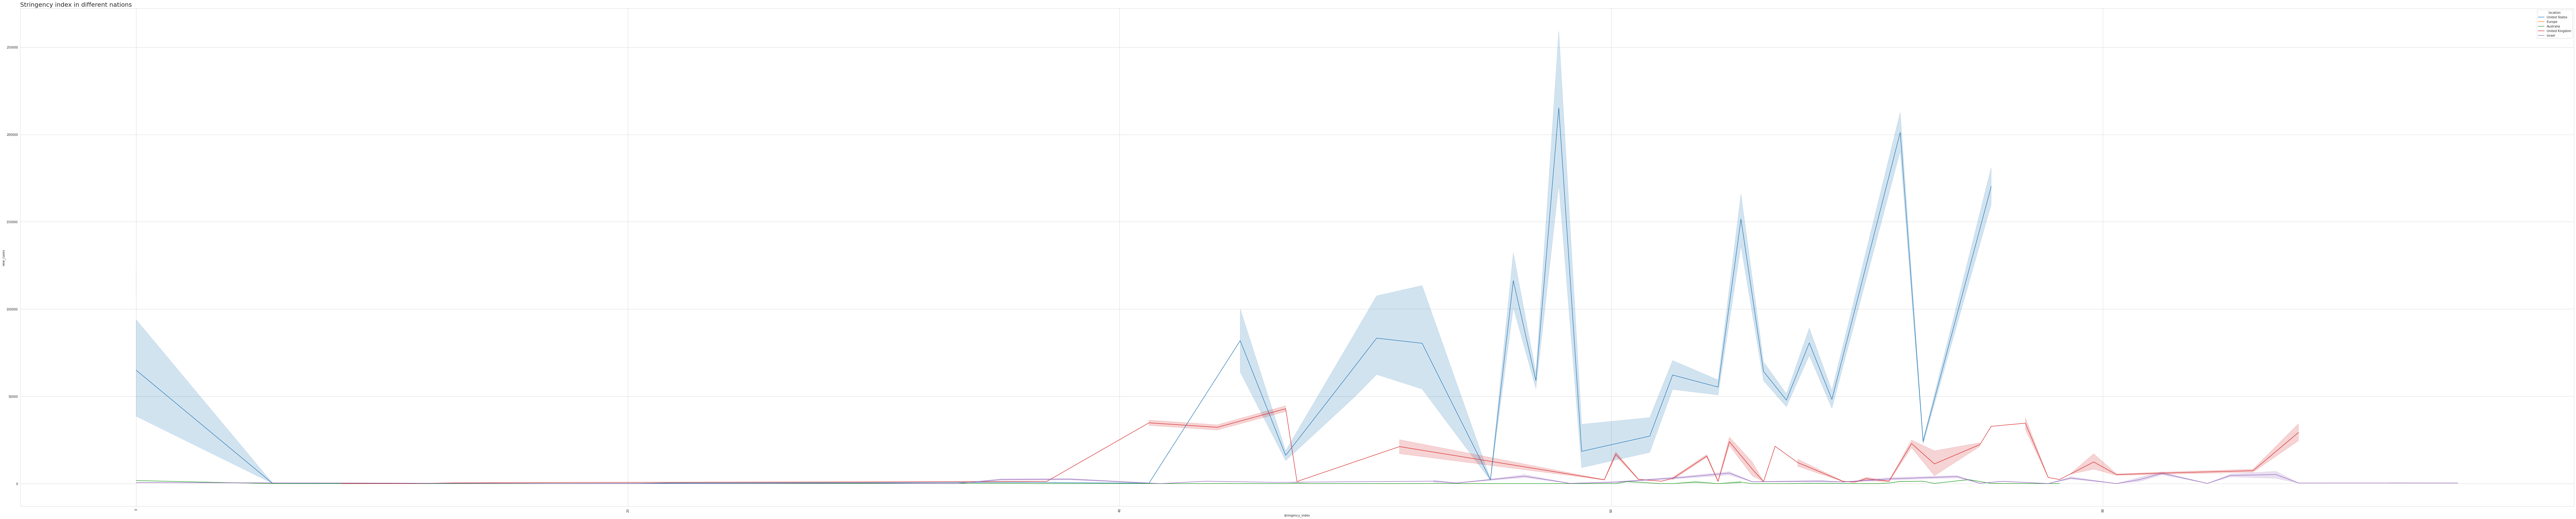

In [29]:
#Plotting Stringency index in different nations
plt.figure(figsize=(150,30))
plt.title('Stringency index in different nations',fontsize = 20,loc='left')
sns.lineplot(data=cdata[cdata['location'].isin(['United States','Israel','United Kingdom','Europe','Australia'])].sort_values(by='date'), x='stringency_index', y='new_cases',hue='location')
plt.xticks(rotation = 'vertical')
plt.show()

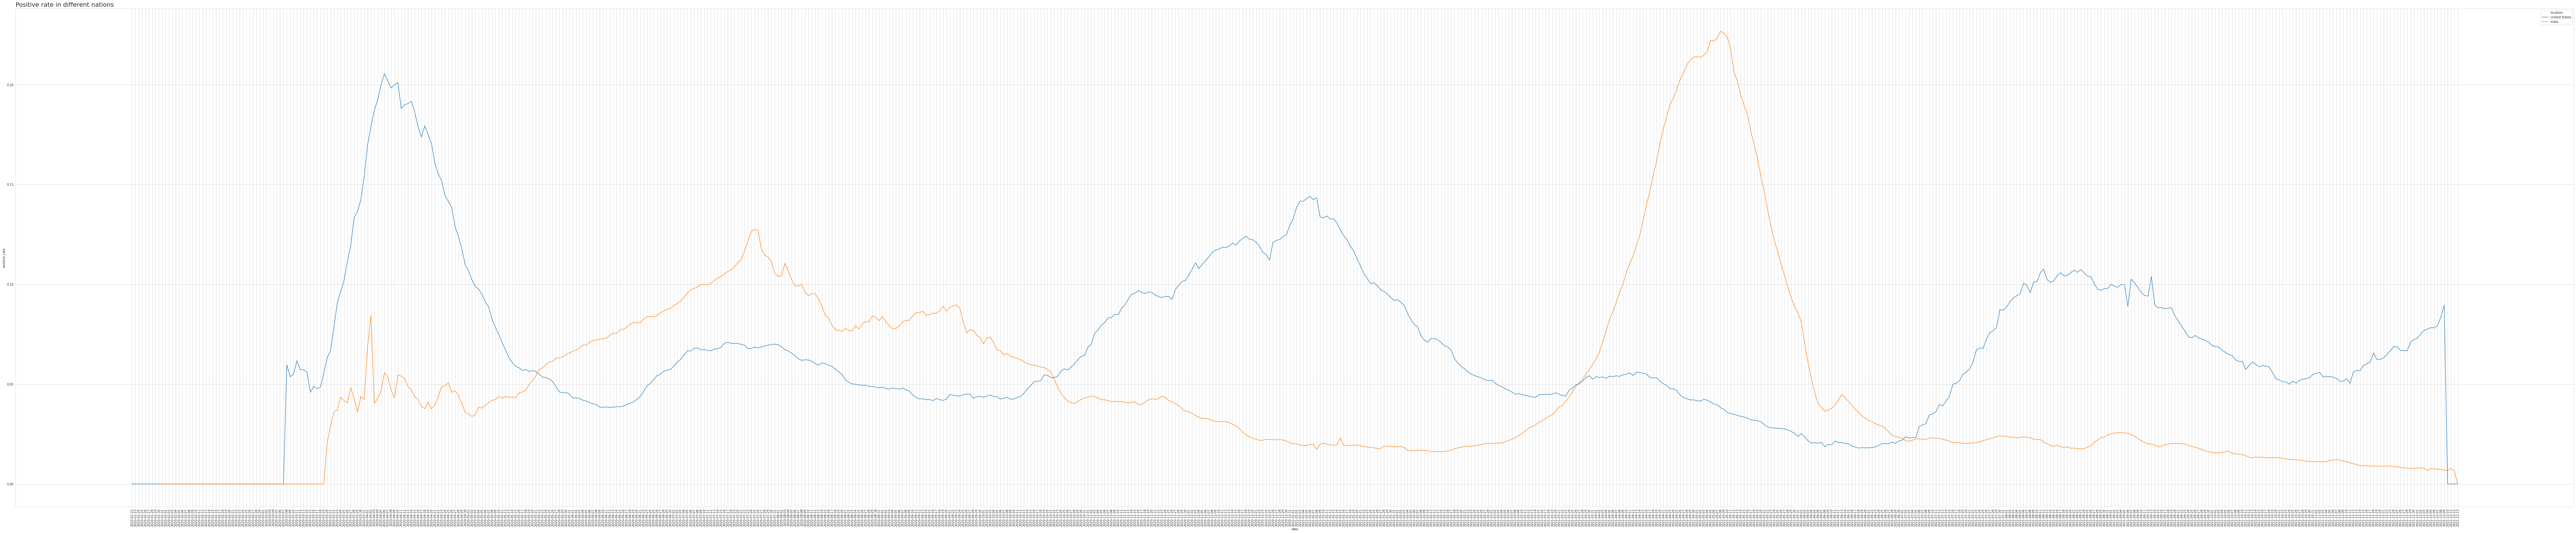

In [30]:
#Plotting Positive rate in different nations
plt.figure(figsize=(150,30))
plt.title('Positive rate in different nations',fontsize = 20,loc='left')
sns.lineplot(data=cdata[cdata['location'].isin(['United States','India'])].sort_values(by='date'), x='date', y='positive_rate',hue='location')
plt.xticks(rotation = 'vertical')
plt.show()

# FBProphet Forecast

In [31]:
#FBProphet model
def forecast(nation):
  data = cdata[cdata['location'].isin([nation])].sort_values(by="date")[['date',"new_cases_per_million"]]
  data.columns = ['ds','y']
  model = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,interval_width=0.95)
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(data)
  future = model.make_future_dataframe(periods=365, freq='D')
  pred = model.predict(future)
  model.plot(pred);
  model.plot_components(pred);


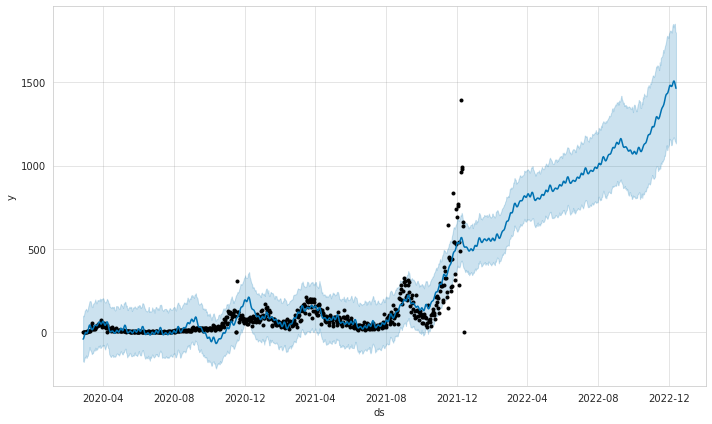

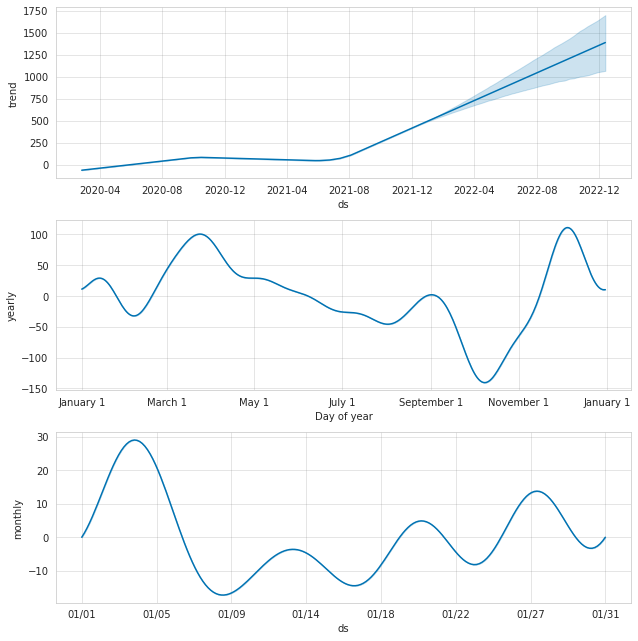

In [32]:
m = forecast('Norway');

In [33]:
#future = list()
#for i in range(1, 13):
#  date = '2021-%01d' % i
#  future.append([date])
#for i in range(1, 13):
#  date = '2022-%12d' % i
#  future.append([date])
#future = DataFrame(future)
#future.columns = ['ds']
#future['ds']= to_datetime(future['ds'])

### FBProphet forecast with regressor 

In [34]:
#FBProphet model with regressor
def forecast2(nation):
  data2 = cdata[cdata['location'].isin([nation])].sort_values(by="date").rename(columns={'new_cases_per_million':'y','date':'ds'})
  model2 = Prophet(weekly_seasonality=False,yearly_seasonality=True,interval_width=0.95)
  model2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  temp = cdata[cdata['location'].isin([nation])].sort_values(by="date")

  def positive_rate(ds):
    date = (pd.to_datetime(ds)).date()
    return (temp['positive_rate']).values[0]

  def stringency_index(ds):
    date = (pd.to_datetime(ds)).date()
    return (temp['stringency_index']).values[0]    

  #model2.add_regressor('positive_rate')
  model2.add_regressor('stringency_index')
  model2.fit(data2)

  future2 = model2.make_future_dataframe(periods=365)
  #future2['positive_rate'] = future2['ds'].apply(positive_rate)
  future2['stringency_index'] = future2['ds'].apply(stringency_index)
  
  pred2 = model2.predict(future2)
  model2.plot(pred2);
  
  #future2['positive_rate'] = temp['positive_rate'] 
  #future2['people_vaccinated_per_hundred'] = temp['people_vaccinated_per_hundred']

In [35]:
#FBProphet model without regressor
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools


def forecast3(nation):
  data = cdata[cdata['location'].isin([nation])].sort_values(by="date")[['date',"new_cases_per_million"]]
  data.columns = ['ds','y']
  model = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,interval_width=0.95)
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(data)
  future = model.make_future_dataframe(periods=365, freq='D')
  pred = model.predict(future)
  model.plot(pred);

  df_cv = cross_validation(model, initial='365 days', period='90 days', horizon = '200 days')
  df_p = performance_metrics(df_cv)
  #print(df_p))
  fig3 = plot_cross_validation_metric(df_cv, metric='rmse')
  
  

In [36]:
#List of countries with high new cases, positive rate and people_fully_vaccinated_per_hundred
clist = cdata.sort_values(by="new_cases_per_million",ascending=False)
clist2 = clist.sort_values(by="people_fully_vaccinated_per_hundred",ascending=False)
clist2 = clist.sort_values(by="positive_rate",ascending=False)
clist2['location'].head(2000).unique()

array(['Uganda', 'Papua New Guinea', 'Palestine',
       'Bosnia and Herzegovina', 'Gabon', 'Bolivia', 'Peru', 'Botswana',
       'Senegal', 'Madagascar', 'Iran', 'Mexico', 'Guatemala',
       'Dominican Republic', 'Namibia', 'Armenia', 'Ukraine', 'Poland',
       'Argentina', 'Trinidad and Tobago', 'Tunisia', 'Mongolia',
       'Croatia', 'Nepal', 'Paraguay', 'Democratic Republic of Congo',
       'Serbia', 'Slovenia', 'Spain', 'Ecuador', 'Costa Rica', 'Jamaica',
       'Panama', 'Albania', 'Bulgaria', 'North Macedonia', 'Laos',
       'Sri Lanka', 'Timor', 'Myanmar', 'Fiji', 'Thailand', 'Malawi',
       'Zimbabwe', 'Chile', 'Oman', 'Mozambique', 'Hungary',
       'United Kingdom', 'Bangladesh', 'Colombia'], dtype=object)

In [37]:
#data = cdata[cdata['location'].isin(['United Kingdom'])].sort_values(by="date")[['date',"new_cases_per_million"]]
#data.set_index('date', inplace=True)
#c = data.loc['0':'2021-04-30']
#df = c.reset_index()
#df.columns = ['ds','y']
#model = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,interval_width=0.95)
#model.fit(df)
#future = model.make_future_dataframe(periods=365, freq='D')
#pred = model.predict(future)
#model.plot(pred);

In [38]:
#FBProphet model without regressor and feeding partial data til 2021-04-30
def forecast4(nation):
  data = cdata[cdata['location'].isin([nation])].sort_values(by="date")[['date',"new_cases_per_million"]]
  data.set_index('date', inplace=True)
  c = data.loc['0':'2021-04-30']
  df = c.reset_index()
  df.columns = ['ds','y']
  model = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,interval_width=0.95)
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(df)
  future = model.make_future_dataframe(periods=365, freq='D')
  pred = model.predict(future)
  model.plot(pred);


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-02-26 00:00:00 and 2021-05-27 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

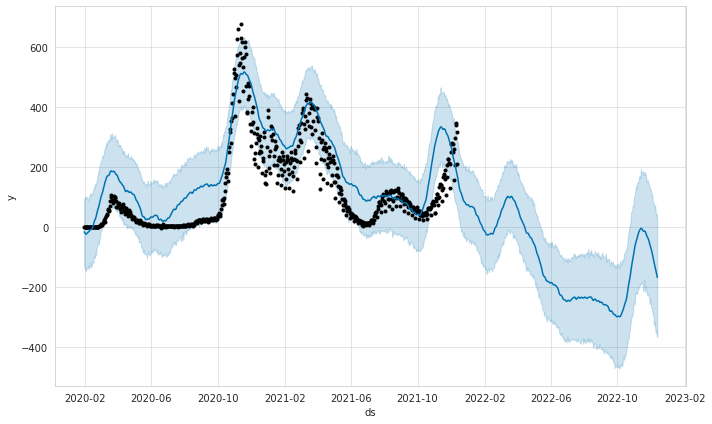

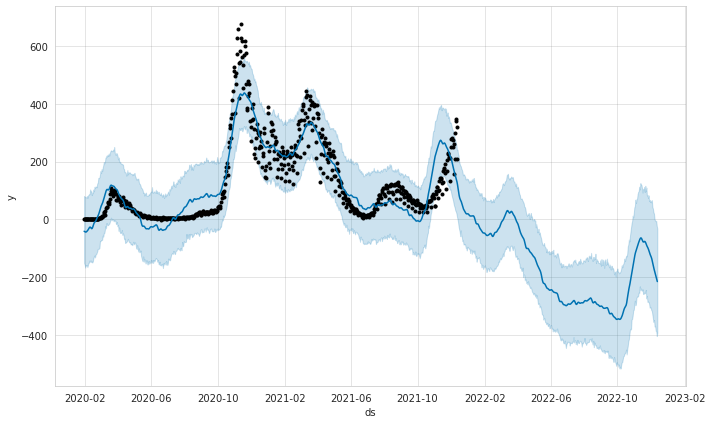

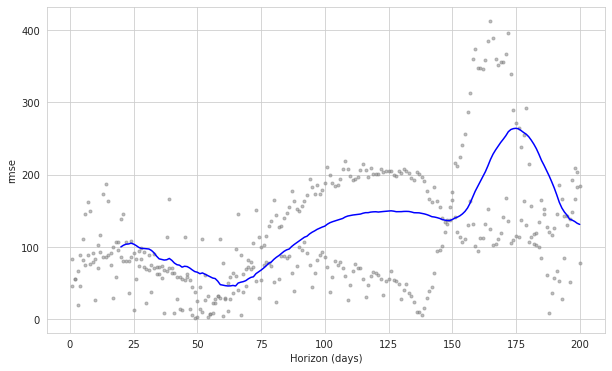

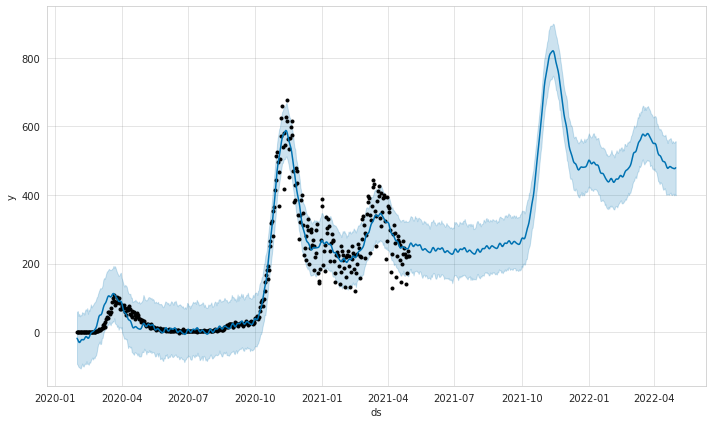

In [39]:
forecast2('Italy')
forecast3('Italy')
forecast4('Italy')


# Hyper-parameter Tunning


In [40]:
def Tunning(nation):  
  data = cdata[cdata['location'].isin([nation])].sort_values(by="date")[['date',"new_cases_per_million"]]
  data.columns = ['ds','y']

  def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

  def single_cv_run(history_df, metrics, param_dict):
    m = Prophet(**param_dict)
    m.fit(history_df)
    df_cv = cross_validation(m, initial='400 days', period='90 days', horizon = '180 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    #df_p = df_p.loc[:, metrics]
    df_p = df_p.reindex(columns = metrics)
    return df_p

  param_grid = {  
                'changepoint_prior_scale': [0.005, 0.05, 0.5, 5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                'growth': ['linear'],
                'yearly_seasonality': [5, 10, 20]
              }

  metrics = ['horizon', 'rmse', 'mape', 'params'] 
  results = []
  params_df = create_param_combinations(**param_grid)
  for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(data,  metrics, param_dict)
    results.append(cv_df)
  results_df = pd.concat(results).reset_index(drop=True)
  best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
  print(f'\n The best param combination is {best_param.values[0][0]}')
  m = best_param.values[0][0]
  return m

In [41]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools

def final_forecast(nation):
  q = Tunning(nation)
  #print("Q:",q)
  n = ast.literal_eval(q)
  m = ast.literal_eval(q)
  dd = []
  for key, value in m.items():
    print(str(key), str(value))
    dd.append((key,value))

  changepoint_prior_scale = dd[0][0]
  changepoint_prior_scale_no = dd[0][1]

  changepoint_range = dd[1][0]
  changepoint_range_no = dd[1][1]

  seasonality_prior_scale = dd[2][0]
  seasonality_prior_scale_no = dd[2][1]

  seasonality_mode = dd[3][0]
  seasonality_mode_no = dd[3][1]

  growth = dd[4][0]
  growth_no = dd[4][1]

  yearly_seasonality = dd[5][0]
  yearly_seasonality_no = dd[5][1]

  def forecast5(nation):
    data = cdata[cdata['location'].isin([nation])].sort_values(by="date")[['date',"new_cases_per_million"]]
    data.set_index('date', inplace=True)
    c = data.loc['0':'2021-04-30']
    df = c.reset_index()
    df.columns = ['ds','y']
    model = Prophet(changepoint_prior_scale= changepoint_prior_scale_no, changepoint_range= changepoint_range_no, seasonality_prior_scale= seasonality_prior_scale_no, seasonality_mode= seasonality_mode_no, growth= growth_no, yearly_seasonality= yearly_seasonality_no)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(df)
    future = model.make_future_dataframe(periods=365, freq='D')
    pred = model.predict(future)
    model.plot(pred);


  def forecast6(nation):
    data = cdata[cdata['location'].isin([nation])].sort_values(by="date")[['date',"new_cases_per_million"]]
    data.columns = ['ds','y']
    model = Prophet(changepoint_prior_scale= changepoint_prior_scale_no, changepoint_range= changepoint_range_no, seasonality_prior_scale= seasonality_prior_scale_no, seasonality_mode= seasonality_mode_no, growth= growth_no, yearly_seasonality= yearly_seasonality_no)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(data)
    future = model.make_future_dataframe(periods=365, freq='D')
    pred = model.predict(future)
    model.plot(pred);

    df_cv = cross_validation(model, initial='365 days', period='90 days', horizon = '200 days')
    df_p = performance_metrics(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='rmse')

  forecast5(nation)
  forecast6(nation) 

In [42]:
clist = cdata.sort_values(by="new_cases_per_million",ascending=False)
clist2 = clist.sort_values(by="people_fully_vaccinated_per_hundred",ascending=False)
clist2 = clist.sort_values(by="positive_rate",ascending=False)
clist2['location'].head(5000).unique()

array(['Uganda', 'Papua New Guinea', 'Palestine',
       'Bosnia and Herzegovina', 'Gabon', 'Bolivia', 'Peru', 'Botswana',
       'Senegal', 'Madagascar', 'Iran', 'Mexico', 'Guatemala',
       'Dominican Republic', 'Namibia', 'Armenia', 'Ukraine', 'Poland',
       'Argentina', 'Trinidad and Tobago', 'Tunisia', 'Mongolia',
       'Croatia', 'Nepal', 'Paraguay', 'Democratic Republic of Congo',
       'Serbia', 'Slovenia', 'Spain', 'Ecuador', 'Costa Rica', 'Jamaica',
       'Panama', 'Albania', 'Bulgaria', 'North Macedonia', 'Laos',
       'Sri Lanka', 'Timor', 'Myanmar', 'Fiji', 'Thailand', 'Malawi',
       'Zimbabwe', 'Chile', 'Oman', 'Mozambique', 'Hungary',
       'United Kingdom', 'Bangladesh', 'Colombia', 'Belgium',
       'South Africa', 'Czechia', 'Saint Vincent and the Grenadines',
       'Ghana', 'Maldives', 'Moldova', 'Indonesia', 'Zambia', 'Singapore',
       'Romania', 'Nigeria', 'Gambia', "Cote d'Ivoire", 'Netherlands',
       'Andorra', 'Philippines', 'Switzerland', 'Urugua

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-03-18 00:00:00 and 2021-06-16 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 The best param combination is {'changepoint_prior_scale': 0.05, 'changepoint_range': 0.8, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'growth': 'linear', 'yearly_seasonality': 10}
changepoint_prior_scale 0.05
changepoint_range 0.8
seasonality_prior_scale 1.0
seasonality_mode multiplicative
growth linear
yearly_seasonality 10


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2021-02-26 00:00:00 and 2021-05-27 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

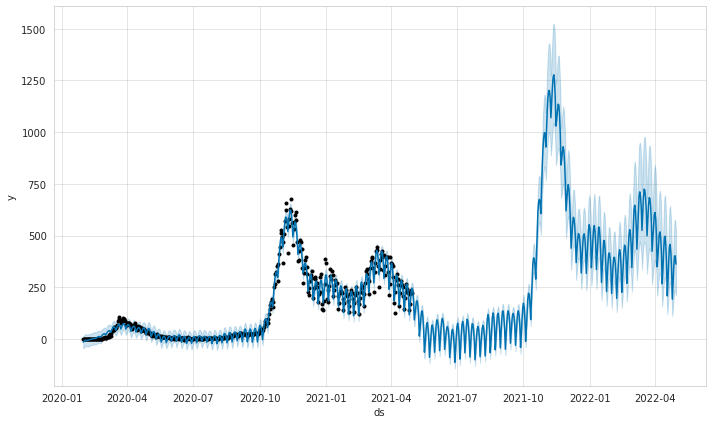

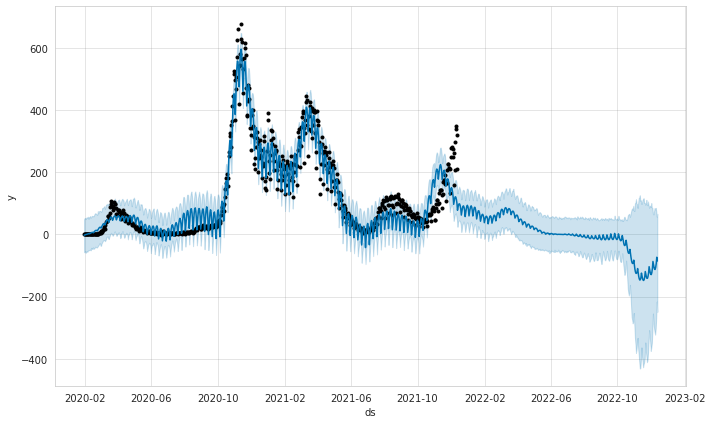

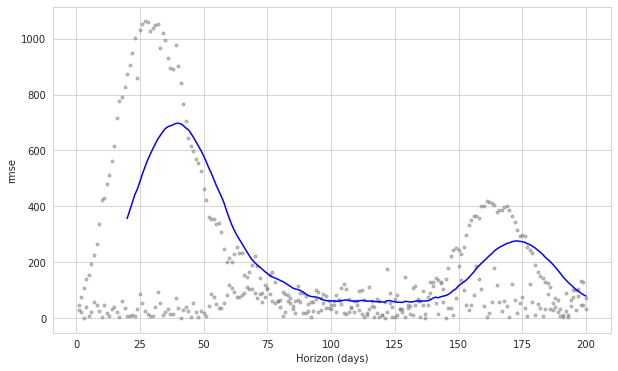

In [46]:
#Tunning('Thailand')
final_forecast('Italy')